## Задание: 
Мы - онлайн магазин спортивных товаров: одежды, обуви, аксессуаров и спорт-питания. На главной странице магазина мы показываем пользователям баннеры с целью стимулирования своих продаж. Сейчас там случайно показывается один из 5 баннеров. Каждый баннер рекламирует конкретный продукт или всю компанию. Наши маркетологи считают, что опыт взаимодействия с баннерами может различаться по сегментам, а их эффективность - зависеть от особенностей пользовательского поведения. <br/>
У менеджера компании появилось предложение от партнеров: продать это место для баннера и рекламировать там другой сервис (оплата предполагается по CPC-модели, т.е. стоимость за клик) <br/><br/>
*Помогите менеджеру принять решение - нужно ли продавать это место для рекламы другого сервиса*

**Описание данных:** У вас есть информация о том, какой баннер показался пользователю, кликнул ли он на него, а так же информация о покупках пользователей. <br/><br/>
title - тип события (показ, клик или покупка) <br/>
user - уникальный идентификатор клиента <br/>
product - продукт баннера/покупки <br/>
page_id - уникальный номер страницы для связки событий (NA для покупок) <br/>
order_id - уникальный номер покупки (NA для кликов и показов баннера) <br/>
time - время совершения действия <br/>
site_version - версия сайта (мобильная или десктопная) <br/>


Начнем с импорта нужных библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

### Исследовательский анализ, обработка и очистка данных.
Прочитаем файл с данными и выведем информацию о первых 5 строках

In [2]:
df = pd.read_csv('C:/ha_data.csv', sep=';')
display(df.head())

,order_id,page_id,product,site_version,time,title,user
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1


In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471226 entries, 0 to 8471225
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   order_id      float64
 1   page_id       float64
 2   product       object 
 3   site_version  object 
 4   time          object 
 5   title         object 
 6   user          object 
dtypes: float64(2), object(5)
memory usage: 452.4+ MB


None

Выводы после первичного осмотра данных можно сделать такие:
* в датасете около 8.5 миллионов строк
* имеется столбец с датой, который записан строкой

Теперь стоит проверить данные на пропуски

In [4]:
df.isna().sum()

order_id        8222504
page_id          248722
product               0
site_version          0
time                  0
title                 0
user                  0
dtype: int64

В условии задачи было указано, что пропуски в столбце order_id означают клик и показ банера, а пропуски в столбце page_id это покупки. Значит данные не утеряны, нам просто в дальнейшем будет удобнее заменить пропуски на соответствующие категории. Можно проверить соответствие количества пропусков типу показа.

In [5]:
df['title'].value_counts()

title
banner_show     7393319
banner_click     829185
order            248722
Name: count, dtype: int64

Действительно, цифры сходятся. у нас 8.2 млн показа и кликов и 250 тыс покупок.

Теперь можно изменить типы в столбцах на более подходящие

In [6]:
df['time'] = pd.to_datetime(df['time'])

Также имеются пропуски в order_id (потому что покупка — это отдельное событие), здесь их можно оставить как есть.

In [7]:
#проверим наличие дубликатов
df.duplicated().sum()

0

### Построение метрик для анализа баннеров
Создадим сводную таблицу, чтобы посмотреть на поведение пользователей по типам событий:

In [8]:
banner_stats = df.pivot_table(
    index='product', 
    columns='title', 
    values='user', 
    aggfunc='count', 
    fill_value=0
)
display(banner_stats)

title,banner_click,banner_show,order
product,,,
accessories,136254,1440954,44551
clothes,220595,1453128,112715
company,144821,1580238,0
sneakers,182597,1453029,67719
sports_nutrition,144918,1465970,23737


Для большей наглядности выведем график

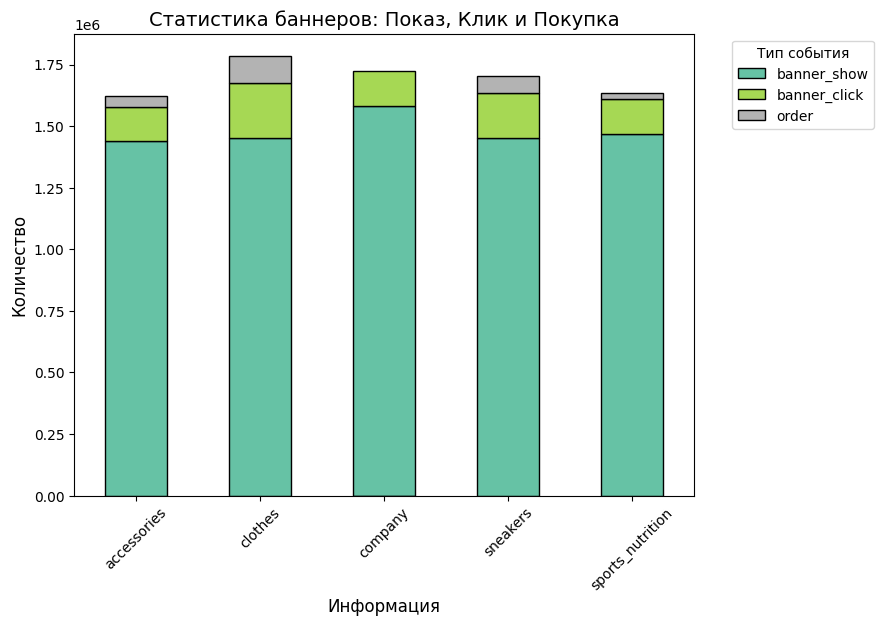

In [9]:
banner_stats = banner_stats[['banner_show', 'banner_click', 'order']]

ax = banner_stats.plot(
    kind='bar', 
    stacked=True, 
    figsize=(8, 6),
    colormap='Set2',
    edgecolor='black'
)

# Настройки графика
plt.title('Статистика баннеров: Показ, Клик и Покупка', fontsize=14)
plt.xlabel('Информация', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Тип события', bbox_to_anchor=(1.05, 1), loc='upper left')

# Отображаем график
plt.show()

Получаем, что больше всего люди кликали и покупали на банеры с одеждой и обувью.

Посчитаем CTR (Click-Through Rate) для каждого баннера: <br/>
**CTR** = Количество кликов / Количество показов

In [10]:
data_banner = df[df['title'] == 'banner_show']
data_clicks = df[df['title'] == 'banner_click']

# Считаем количество показов и кликов для каждого баннера
shows = data_banner.groupby('product').size()
clicks = data_clicks.groupby('product').size()

# Вычисляем CTR
ctr = (clicks / shows).fillna(0)
print(ctr)

product
accessories         0.094558
clothes             0.151807
company             0.091645
sneakers            0.125666
sports_nutrition    0.098855
dtype: float64


Данная метрика покажет насколько "желанными" для клика были каждый из банеров. Исходя из полученных значений можно сделать выводы, что самый желаемый банер - с одеждой. В данном случае 15% пользователей, увидевших баннер, кликнули на него.

Теперь посчитаем конверсию в покупку (CR): <br/>
**CR** = Количество покупок / Количество кликов

In [11]:
data_purchase = df[df['title'] == 'order']
purchases = data_purchase.groupby('product').size()

# Вычисляем CR
cr = (purchases / clicks).fillna(0)
print(cr)

product
accessories         0.326970
clothes             0.510959
company             0.000000
sneakers            0.370866
sports_nutrition    0.163796
dtype: float64


Теперь расшифруем каждую конверсию: 

* Accessories: 0.327 - Примерно **каждый третий** кликнувший пользователь совершил покупку.
* Clothes: 0.511 - Примерно **каждый второй** кликнувший пользователь совершил покупку.
* Company: 0.000 - **Ни один** кликнувший пользователь не совершил покупку.
* Sneakers: 0.371 - Примерно **каждый третий** кликнувший пользователь совершил покупку.
* Sports Nutrition: 0.164 - Примерно **каждый шестой** кликнувший пользователь совершил покупку.

Подводя итог, можно сделать вывод что у баннеров довольно хорошая конверсия в покупку, учитывая клики на банер. Если не считать банер с информацией о компании, остальные в большинстве своем неплохо справляются с задачей продать товар.

### Сравнение эффективности баннеров с CPC-моделью
Вычислим прибыль от каждого баннера: <br/>
Например, если мы знаем среднюю прибыль с одной покупки (допустим, 100 у.е.), можно рассчитать общий доход:

In [12]:
average_revenue_per_order = 100  # Предполагаем
total_revenue = (purchases * average_revenue_per_order).sum()
print(f"Общая выручка: {total_revenue}")

Общая выручка: 24872200


Вычислим предполагаемую прибыль от продажи баннерного места по CPC: <br/>
Предположим, что за каждый клик рекламодатель платит 5 у.е..

In [13]:
cpc_revenue = clicks.sum() * 5
print(f"CPC Выручка: {cpc_revenue}")

CPC Выручка: 4145925


In [14]:
print('Общая выручка больше в', total_revenue/cpc_revenue, 'раз')

Общая выручка больше в 5.9991919776648155 раз


Средний заказ и средняя стоимость клика дают лишь приблизительную картину. Но если баннеры приносят значимые продажи, стоит рассмотреть, насколько доход от продаж превышает потенциальный доход от CPC-рекламы. На основании таких данных сложно сделать выводы, но даже в примерной модели выручка за уже имеющиеся баннеры больше в 6 раз. 

### Проверка гипотезы о различном поведении в разных сегментах

В условии задачи упоминалось, что маркетологи считают, что взаимодействие с баннерами различается по сегментам и зависит от поведения пользователей. Мы можем использовать проверку статистических различий между сегментами пользователей, для того чтобы проверить эту теорию. <br/><br/>
Сегменты могут быть построены на основе: <br/>
* Версии сайта: десктоп / мобильная (столбец site_version) 
* Продукта (категория баннера)
* Активность пользователей: кликавшие или нет / покупавшие или нет



In [15]:
# Сводная таблица для подсчёта количества показов, кликов и покупок по сегментам
segmented_stats = df.pivot_table(
    index=['site_version', 'product'], 
    columns='title', 
    values='user', 
    aggfunc='count', 
    fill_value=0
)

# Рассчитаем CTR и CR для каждого сегмента
segmented_stats['CTR'] = segmented_stats['banner_click'] / segmented_stats['banner_show']
segmented_stats['CR'] = segmented_stats['order'] / segmented_stats['banner_show']

display(segmented_stats)


title                          banner_click  banner_show  order       CTR  \
site_version product                                                        
desktop      accessories              18531       410003  22121  0.045197   
             clothes                  32781       418070  66977  0.078410   
             company                  28464       477374      0  0.059626   
             sneakers                 21419       411598  32565  0.052039   
             sports_nutrition         13870       417595  11518  0.033214   
mobile       accessories             117723      1030951  22430  0.114189   
             clothes                 187814      1035058  45738  0.181453   
             company                 116357      1102864      0  0.105504   
             sneakers                161178      1041431  35154  0.154766   
             sports_nutrition        131048      1048375  12219  0.125001   

title                                CR  
site_version product                     
desktop      accessories       0.053953  
             clothes           0.160205  
             company           0.000000  
             sneakers          0.079118  
             sports_nutrition  0.027582  
mobile       accessories       0.021757  
             clothes           0.044189  
             company           0.000000  
             sneakers          0.033755  
             sports_nutrition  0.011655

Для дальнейших выводов посчитаем отдельно средний CTR и CR для разных версий сайта.

In [16]:
# Группируем данные по версии сайта и рассчитываем средний CTR и CR
average_stats = segmented_stats.groupby('site_version')[['CTR', 'CR']].mean()

# Отображаем результат
display(average_stats)

title,CTR,CR
site_version,,
desktop,0.053697,0.064172
mobile,0.136183,0.022271


Для этой сводной таблицы также визуализируем данные.

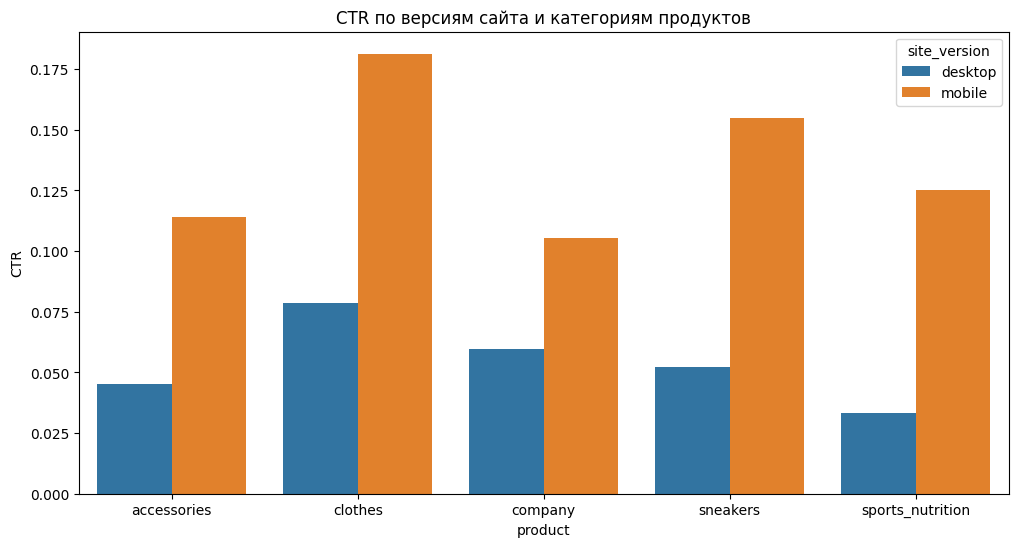

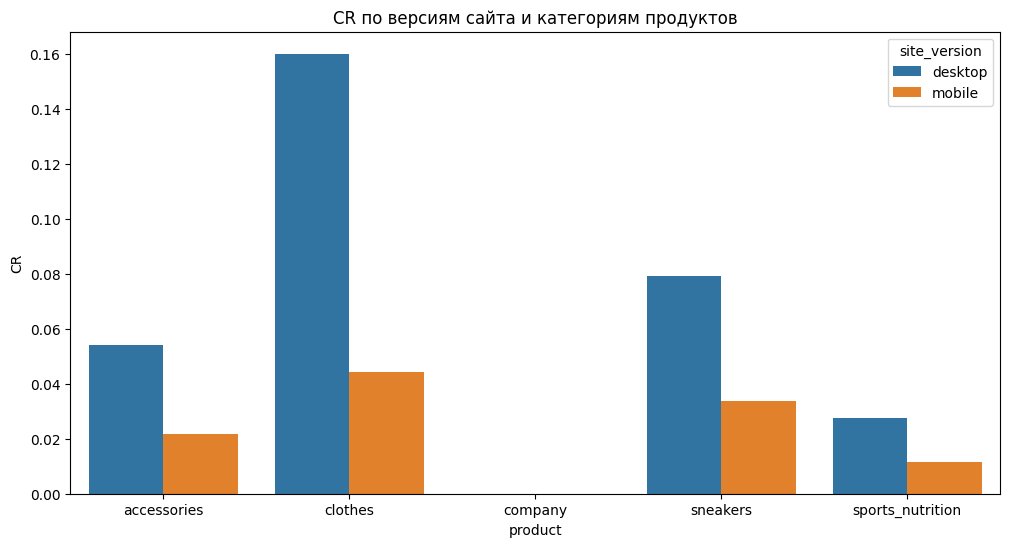

In [18]:
# Преобразуем данные для визуализации в формат DataFrame
segmented_stats_reset = segmented_stats.reset_index()

# График CTR по версиям сайта и продуктам
plt.figure(figsize=(12, 6))
sns.barplot(data=segmented_stats_reset, x='product', y='CTR', hue='site_version')
plt.title('CTR по версиям сайта и категориям продуктов')
plt.show()

# График CR по версиям сайта и продуктам
plt.figure(figsize=(12, 6))
sns.barplot(data=segmented_stats_reset, x='product', y='CR', hue='site_version')
plt.title('CR по версиям сайта и категориям продуктов')
plt.show()

Выводы неоднозначны. В мобильной версии метрика CTR больше, чем в десктопной, что значит пользователи чаще кликали на все банеры, в среднем это значение составляет 0.13 против 0.05. Но не смотря на это, в десктопной версии больше метрика CR(0.06 против 0.02), что означает большее количество покупок. <br/>
**Можно сделать вывод, что в мобильной версии пользователи больше кликают и смотрят сайт, а в десктопной покупают.**

### Проверка статистической значимости нашей гипотезы.
Используем критерий хи-квадрат для проверки различий между сегментами. Он поможет проверить, являются ли различия в взаимодействии статистически значимыми. 

In [19]:
# Создадим таблицу сопряжённости для кликов на десктопе и мобильной версии
clicks_contingency = pd.crosstab(df['site_version'], df['title'] == 'banner_click')

# Применим тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(clicks_contingency)

print(f'Хи-квадрат: {chi2}, p-value: {p}')

Хи-квадрат: 92351.66100733451, p-value: 0.0


P-уровень значимости получился близок к 0, следовательно мы можем отклонить нулевую гипотезу о том, что между поведениями в сегментах нет различия. Это было итак довольно очевидно, смотря на графики, но проверить стоило.

### Итоговый вывод:
Маркетологи оказались правы, предположив что между разными сегментами пользователей есть различия в поведении. Проведя исследовательский анализ эти различия были обнаружены:

Различие в метриках по сегментам:

* CTR выше в **мобильной версии**, что может указывать на лучшее восприятие баннеров или более удобный интерфейс для **кликов**.
* CR выше на **десктопе**, что говорит о том, что на этой версии сайта пользователи **склонны совершать покупки** после взаимодействия с баннерами.

Это различие важно учитывать при оценке эффективности баннеров и принятии решения: оба сегмента приносят пользу, но с разными акцентами (мобильные пользователи кликают, а десктопные — покупают).
Исходя из этого, можно сказать, что баннеры стимулируют продажи, особенно для рекламируемых товаров.
Средний заказ и средняя стоимость клика дают лишь приблизительную картину. Но если баннеры приносят значимые продажи, стоит рассмотреть, насколько доход от продаж превышает потенциальный доход от CPC-рекламы. <br/><br/>

**Рекомендации:**

Дать итоговый ответ довольно сложно, так как отсуствует информация о суммах заказов и цене, предлагаемой за клик. Есть несколько вариантов: 

* Узнать и посчитать доход от продаж, стимулируемых баннерами, и если он значительно превышает потенциальный доход от внешней рекламы, то оставить свои баннеры.
* Если доход от внешней рекламы выглядит более выгодным или стабильным, стоит рассмотреть продажу места.
* Также можно провести A/B тестирование: на части трафика разместить рекламу внешнего сервиса и сравнить доход с текущими показателями.

Если же от аналитика требуется дать решение задачи учитывая только имеющиеся данные, то **рекомендую оставить текущие баннеры.**